In [1]:
import xarray as xr
import pysumma as ps
import geopandas as gpd
import cartopy.crs as ccrs
import pysumma.plotting as psp
import matplotlib.pyplot as plt
from utils.read_files import read_from_control, make_default_path
from pathlib import Path

In [2]:
# Store the name of the 'active' file in a variable
basin = "EastRiver"
controlFile = f'control_{basin}.txt'

In [3]:
# Forcing file list path & name
filemanager_path = read_from_control(controlFile,'settings_summa_path')
filemanager_name = read_from_control(controlFile,'settings_summa_filemanager')


# Forcing file list path & name
filemanager_path = read_from_control(controlFile,'settings_summa_path')
filemanager_name = read_from_control(controlFile,'settings_summa_filemanager')
# Specify default path if needed
if filemanager_path == 'default':
    filemanager_path = make_default_path('settings/SUMMA', controlFile) # outputs a Path()
else:
    filemanager_path = Path(filemanager_path) # make sure a user-specified path is a Path()


# Make the folder if it doesn't exist
filemanager_path.mkdir(parents=True, exist_ok=True)

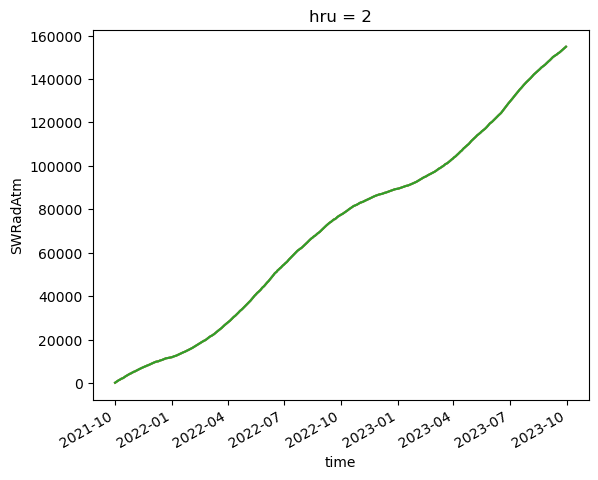

In [4]:
forcing_ds = xr.open_dataset('/storage/dlhogan/summa_modeling_data/domain_EastRiver/forcing/4_SUMMA_input/EastRiver_remapped_EastRiver_forcing_2022_2023.nc')
fig, ax = plt.subplots()
for hru in forcing_ds['LWRadAtm'].hru.values:
    (forcing_ds['SWRadAtm']).sel(hru=hru).cumsum().plot(ax=ax, label="HRU: " + str(hru))

In [5]:
# Update this path to the location of your file manager
file_manager = str(filemanager_path / filemanager_name)
summa_exe = 'summa.exe'

s = ps.Distributed(summa_exe, file_manager, chunk_size=2)
s.simulations.keys()

dict_keys(['g1-1'])

In [6]:
%%time
s.run()
print(s.summary())

{'Success': ['g1-1'], 'Error': [], 'Other': []}
CPU times: user 818 ms, sys: 206 ms, total: 1.02 s
Wall time: 15.7 s


In [6]:
s_ds = s.merge_output()

As with the Simulation and Ensemble objects we can simply call .run() to start the simulations running. If you are running this tutorial interactively, this may take a moment because of the limited compute capacity of the binder instance. We have included the %%time magic to time how long this cell takes to run locally. You might expect this to take up to roughly two times the amount of time on the binder instance than is reported in the documentation at pysumma.readthedocs.io. As with the Ensemble we can use the .summary() method once the runs are complete to ensure that they all exit with status Success.

### Basic Visualization

Once we have run a successful simulation you might note that the gru dimension doesn’t contain any geometry data on which we can actually draw our output. To do that we will use the associated shapefile, loaded in via GeoPandas, and plot the mean surface temperature via the psp.spatial functionality. For more information on the spatial plotting capabilities see the plotting page in the documentation. Here we plot the traces of the input precipitation rate and total soil moisture timeseries for each of the HRU as well as a spatial plot showing the mean soil moisture over the simulation period.

In [7]:
s_ds = s_ds.sel(time=slice('2021-10-02', '2023-09-30'))

/home/dlhogan/miniforge3/envs/pysumma/lib/python3.9/site-packages/pysumma/plotting/spatial.py:73: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  patches = gen_patches(data_array, geodf_crs, robust)


<GeoAxes: >

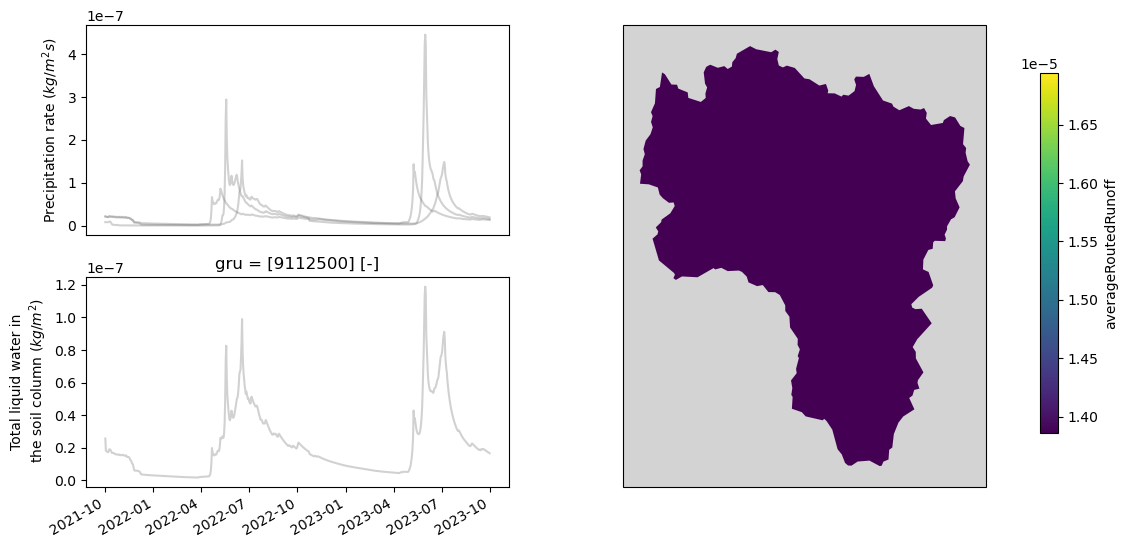

In [8]:
shapefile = '/storage/dlhogan/summa_modeling_data/domain_EastRiver/shapefiles/catchment/EastRiver.shp'
gdf = gpd.GeoDataFrame.from_file(shapefile)

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0], )
s_ds['scalarTotalRunoff'].plot.line(x='time', ax=ax1, add_legend=False, color='dimgrey', alpha=0.3)
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.set_ylabel('Precipitation rate ($kg / m^2 s$)')

ax2 = fig.add_subplot(gs[1, 0], )
s_ds['averageRoutedRunoff'].plot.line(x='time', ax=ax2, add_legend=False, color='dimgrey', alpha=0.3)
ax2.set_ylabel('Total liquid water in\n the soil column ($kg/m^2$)')
ax2.set_xlabel('')

ax3 = fig.add_subplot(gs[:, 1], projection=ccrs.Mercator())
psp.spatial(s_ds['averageRoutedRunoff'].sum(dim='time'), gdf, ax=ax3, robust=[0,1e-5])

In [9]:
gdf.to_crs(epsg="32613").area

0    7.487056e+08
dtype: float64

## Further configuration, and more advanced parallelism

The Yakima River Basin given as an example here is a relatively small simulation of about 300 HRU for a month, but the parallelism approach built into the Distributed object can generally scale to many cores. Under the hood we rely on the `dask library <https://dask.org/>`__ to manage the scheduling of the parallel runs of both the Ensemble and Distributed objects. While we won’t actually run any simulations with these configurations, we show the code as a reference.

In [10]:
from dask.distributed import Client
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster

In [11]:
from dask.distributed import Client



In [12]:
# Local example
N_WORKERS = 16 # A big machine might have 16 processors
local_cluster = LocalCluster(n_workers=N_WORKERS, threads_per_worker=1) # Each SUMMA simulation runs as a single-threaded process by default
local_example = Client(local_cluster) # This connects the compute cluster to the process running in this notebook

# Print the dashboard link
print(local_example.dashboard_link)
yakima_local = ps.Distributed(summa_exe, file_manager, client=local_example)


/home/dlhogan/miniforge3/envs/pysumma/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33886 instead
  warnings.warn(


http://127.0.0.1:33886/status


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 1

2025-03-07 15:29:57,795 - distributed.nanny - WARNING - Restarting worker
2025-03-07 15:29:57,849 - distributed.nanny - WARNING - Restarting worker
2025-03-07 15:29:57,920 - distributed.nanny - WARNING - Restarting worker
2025-03-07 15:29:58,074 - distributed.nanny - WARNING - Restarting worker
2025-03-07 15:29:58,426 - distributed.nanny - WARNING - Restarting worker
2025-03-07 15:29:59,506 - distributed.nanny - WARNING - Restarting worker


In [ ]:
%%time
yakima_local.run()
print(yakima_local.summary())

KeyboardInterrupt: 